In [2]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

def NSE(predictions,targets):
    mse = np.mean((predictions - targets) ** 2)
    nse = 1 - (mse / np.var(targets))
    return nse

def KGE(pred,obs):
    corr,_ = pearsonr(pred,obs)
    kge = 1- np.sqrt((np.std(pred)/np.std(obs) - 1)**2 + (np.mean(pred)/np.mean(obs) - 1)**2 +(corr- 1)**2)
    return kge



modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientDrawdown"

In [3]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']#, 'Qout']

# load output from modflow simulations
outputdf = pd.read_csv('TransOutputStpSteadyPumpTest.csv') 
#load parameters
sampling = np.loadtxt("ModflowParams7-750Test12.txt") 
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

numTS = 5 #number of time steps to keep from the end
stps = 5 - numTS
outputdf = outputdf[outputdf['Stp'] > stps].set_index('simnum') #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.unique()
timestepidx = outputdf['index'].unique()
pardf = pardf.iloc[simindex]

print(len(timestepidx))
print(outputdf[outputdf['reach'] == 25])
print(pardf.reset_index(drop=True))

148750
         index     Qout  reach  Stp
simnum                             
1           24  165.290     25    1
1           74  153.910     25    2
1          124  147.950     25    3
1          174  145.040     25    4
1          224  142.610     25    5
...        ...      ...    ...  ...
749     148524   33.957     25    1
749     148574   33.184     25    2
749     148624   32.360     25    3
749     148674   31.634     25    4
749     148724   31.214     25    5

[2975 rows x 4 columns]
            K  Low_K_ratio        Sy      Rech  ET_valley  ET_rip_ratio  \
0    0.252596     0.000074  0.058034  0.000203   0.000009      3.185117   
1    0.425213     0.761486  0.108251  0.000293   0.000002      2.180845   
2    0.258080     0.028534  0.218521  0.000174   0.000007      3.005435   
3    0.447384     0.002679  0.071039  0.000184   0.000006      1.934646   
4    0.347367     0.000020  0.239157  0.000223   0.000001      3.860679   
..        ...          ...       ...       ...    

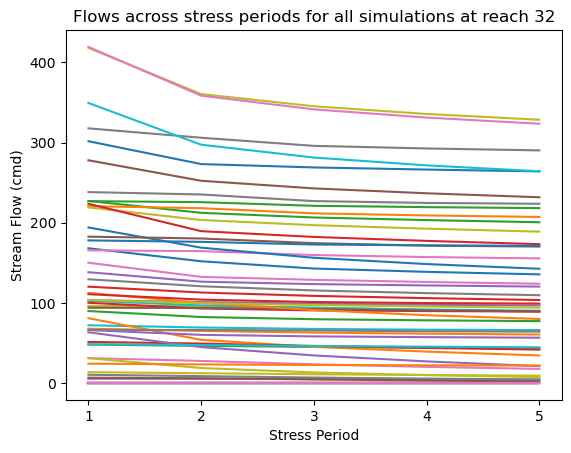

In [4]:
rn = 32

outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(outputs)

for i in range(int(len(outputs)/10)):
    plt.plot(range(1,numTS+1),outputs[i],)
plt.xlabel("Stress Period")
plt.ylabel("Stream Flow (cmd)")
plt.title("Flows across stress periods for all simulations at reach " + str(rn))
#plt.yscale('log')
plt.xticks([i for i in range(1, numTS+1)])
#plt.legend()
plt.show()

# Decision Tree Code
Most of below is from:https://www.datacamp.com/community/tutorials/decision-tree-classification-python

RMSE:  36.03213463596826
Average NSE:  0.8747160999379902
Tree Depth:  16
Stress Period 6 NSE:  0.8740318102860701
Stress Period 5 NSE:  0.8742049790788528
Stress Period 4 NSE:  0.8748465589935217
Stress Period 3 NSE:  0.8749823564502495
Stress Period 2 NSE:  0.8750575995065114
Average KGE:  0.9360263111861477
Plot showing just simulaions with Q > 0


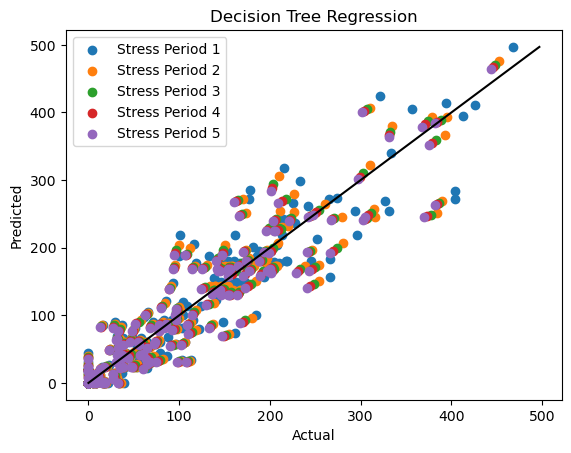

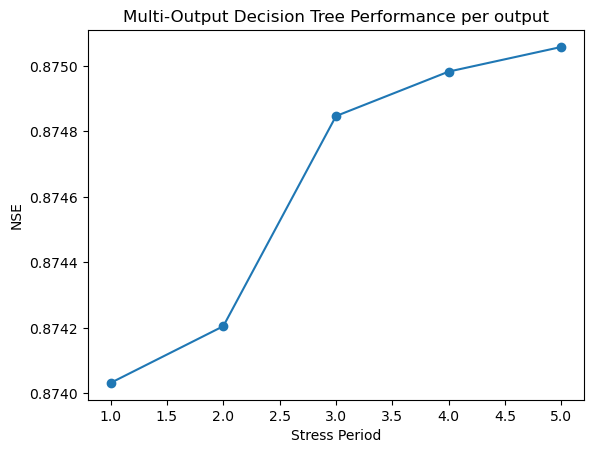

In [5]:
# Split dataset into training set and test set, default here is 30% test
rn  = 25 #reach number
outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this
#print(outputs)

X_train, X_test, y_train, y_test = train_test_split(pardf, outputs, test_size=0.3, random_state=0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor(
   # random_state = 0
   #max_depth = 4

)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", NSE(y_pred, y_test))
#print("KGE: ", KGE(y_pred, y_test))
# print("Corr:",pearsonr(y_pred, y_test))
print("Tree Depth: ", clf.get_depth())
#print(y_test,y_pred)
nselist = []
kgelist = []

for i in range(numTS):
    nselist.append(NSE(y_pred[:,i], y_test[:,i]))
    kgelist.append(KGE(y_pred[:,i], y_test[:,i]))

  #  print("Corr:",pearsonr(y_pred[:,i], y_test[:,i])) 
    print("Stress Period " +str((numTS-i)+1)+ " NSE: ", nselist[i])
    #print("Stress Period " +str(41 - (numTS-i)+1)+ " KGE: ", kgelist[i])
    
print("Average KGE: ", np.mean(kgelist))

print('Plot showing just simulaions with Q > 0')
# Plot the results
plt.figure()
for i in range(numTS):
    plt.scatter(y_test[:,i], y_pred[:,i], label = str("Stress Period " + str(1+i)))
outmax = np.max(outputs)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

plt.scatter(range(1,numTS+1),nselist)
plt.plot(range(1,numTS+1),nselist)
plt.xlabel("Stress Period")
plt.ylabel("NSE")
plt.title("Multi-Output Decision Tree Performance per output")
#plt.legend()
plt.show()

# for i in range(len(y_test)):
#     plt.plot(range(1,numTS+1),y_test[i],)
# plt.xlabel("Stress Period")
# plt.ylabel("Target Flow")
# plt.title("Flows of Test outputs")
# plt.yscale('log')
# #plt.legend()
# plt.show()

In [6]:
#evalTree(clf)

[0.32322006 0.00369567 0.00307101 0.46143462 0.00648006 0.00343432
 0.19866426]
['K' 'Low_K_ratio' 'Sy' 'Rech' 'ET_valley' 'ET_rip_ratio' 'Stream_K_ratio']
Feature: 0, Score: 0.32322
Feature: 1, Score: 0.00370
Feature: 2, Score: 0.00307
Feature: 3, Score: 0.46143
Feature: 4, Score: 0.00648
Feature: 5, Score: 0.00343
Feature: 6, Score: 0.19866


<Axes: >

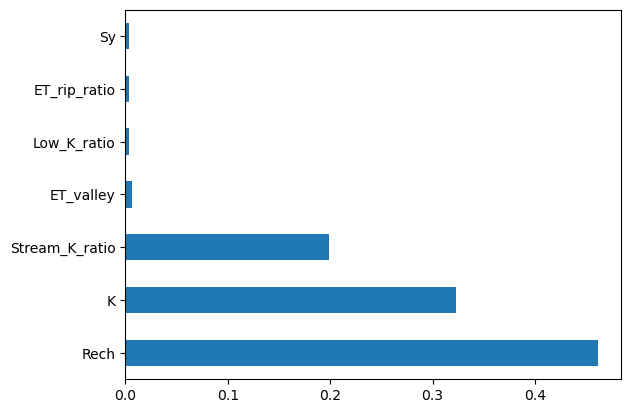

In [7]:
#feature importance
importance = clf.feature_importances_
print(importance)
imp_names = clf.feature_names_in_
print(imp_names)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

feat_importances = pd.Series(clf.feature_importances_, index=clf.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

Reach 1 NSE:  nan
Reach 2 NSE:  0.8439019395768899
Reach 3 NSE:  0.7942909085079793
Reach 4 NSE:  0.8322360867122691
Reach 5 NSE:  0.8706608394813742
Reach 6 NSE:  0.8851407034739618
Reach 7 NSE:  0.8821799734244343
Reach 8 NSE:  0.8795731908164682
Reach 9 NSE:  0.8761553976425285
Reach 10 NSE:  0.8174163270142899
Reach 11 NSE:  0.8317347515520043
Reach 12 NSE:  0.8930191095824195
Reach 13 NSE:  0.8770772346375169
Reach 14 NSE:  0.8741486958319388
Reach 15 NSE:  0.8717590203926915
Reach 16 NSE:  0.8892939608480654
Reach 17 NSE:  0.8916471511054146
Reach 18 NSE:  0.8775680318748764
Reach 19 NSE:  0.8640998464123669
Reach 20 NSE:  0.8799424704313245
Reach 21 NSE:  0.8820603312742261
Reach 22 NSE:  0.8847411480081955
Reach 23 NSE:  0.9011633155738611
Reach 24 NSE:  0.8804734012421587
Reach 25 NSE:  0.8645773158500196
Reach 26 NSE:  0.8774575484208653
Reach 27 NSE:  0.912052764159671
Reach 28 NSE:  0.8948899055272923
Reach 29 NSE:  0.9091893856628902
Reach 30 NSE:  0.907342893382526
Reach 

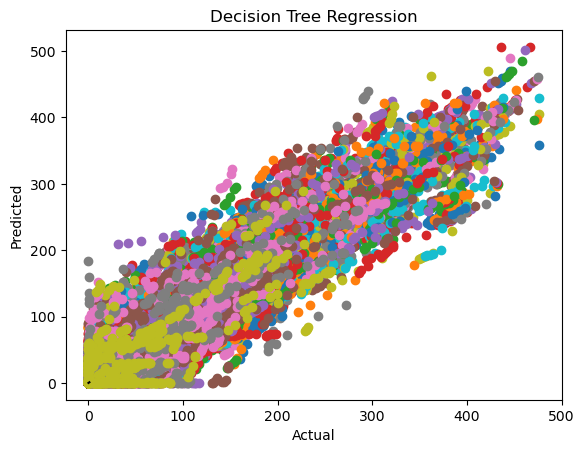

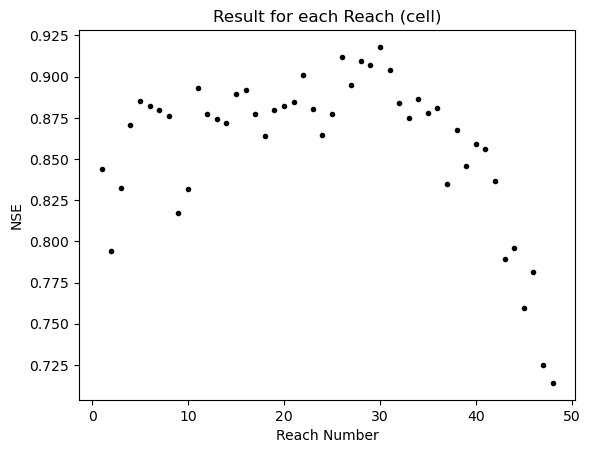

Feature: 0, Score: 0.38621
Feature: 1, Score: 0.11580
Feature: 2, Score: 0.00480
Feature: 3, Score: 0.34317
Feature: 4, Score: 0.00728
Feature: 5, Score: 0.00829
Feature: 6, Score: 0.13445


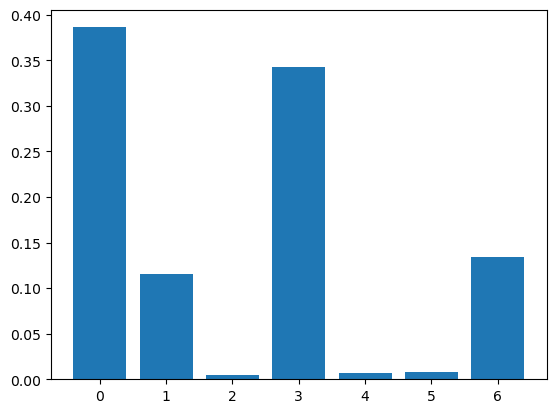

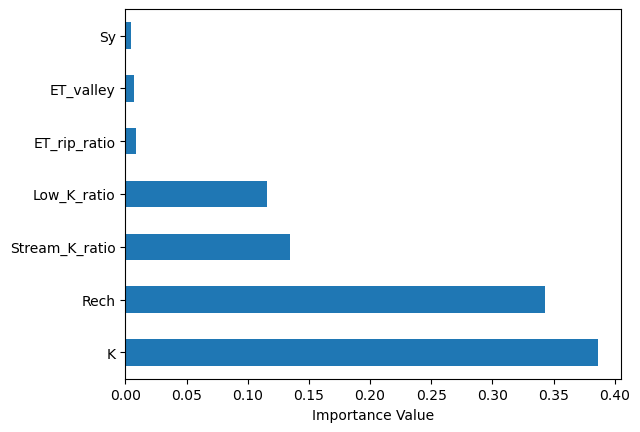

In [8]:
#try to predict Qout with parameters at every reach
reachnum = 50
Reach_importance = []
nse_list = []
simnum = []

for i in range(1,reachnum):
    
    Y3 = np.asarray(outputdf[outputdf['reach'] == i]['Qout']).reshape((len(simindex),numTS))#[:,1] #probably a better way to do this

    X3 = pardf
    
   # numgrz = np.where(Y3 > 0) 
   # print('Number of simulations > 0 : ' + str(numgrz))
    
    # Split dataset into training set and test set, default here is 30% test
    X_train, X_test, y_train, y_test = train_test_split(X3, Y3, test_size=0.3, random_state=0)

    # Create Decision Tree classifer object
    reachTree = DecisionTreeRegressor(
        #random_state = 0
         #max_depth = 9
    )

    # Train Decision Tree Classifer
    reachTree = reachTree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = reachTree.predict(X_test)

    #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#     print("NSE: ", NSE(y_test, y_pred))
#     print("Tree Depth: ", reachTree.get_depth())
    #print("Reach "+str(i)+" RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
    print("Reach "+str(i) + " NSE: ", NSE(y_pred, y_test))
    nse_list.append(NSE(y_pred, y_test))
   # simnum.append(numgrz)
    # Plot the results
    #plt.figure()
    label = "Reach " + str(i)
    plt.scatter(y_test, y_pred, label = label)  

   #plt.legend()


    #feature importance
    importance = reachTree.feature_importances_
    Reach_importance.append(importance)

#outmax = np.max(ReachQ)
outmax = 1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

plt.plot(nse_list, 'k.')

plt.xlabel("Reach Number")
plt.ylabel("NSE")
plt.title("Result for each Reach (cell)")
plt.show()

#feature importance
importance = reachTree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feat_importances = pd.Series(reachTree.feature_importances_, index=reachTree.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh',)
plt.xlabel('Importance Value')
#plt.ylabel('ylabel')
plt.show()
# plt.plot(simnum)

# plt.xlabel("Reach Number")
# plt.ylabel("Number of Simulations with Q > 0")
# plt.title("Number of non-dry simulations for each Reach (cell)")
# plt.show()

## Now for the Wells

In [9]:
#all_well_loc = np.array(np.meshgrid(np.arange(50),np.arange(50))).T.reshape(-1,2)
#print(all_well_loc)

#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))

In [10]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [11]:
#Get Head data for All active wells
import seaborn as sns
sns.set_style("white")

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_error_sim = []
#well_error_num = []

for j, i in enumerate(simindex):
    modelname = "ScenarioSfr750SteadyPumpTest_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
                
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last 2 timesteps - or tryting too
            well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done")          

FileNotFoundError: [Errno 2] No such file or directory: 'D:/mfoutput/transientDrawdown/ScenarioSfr750SteadyPumpTest_1.hds'

In [ ]:
## Delete out simulations where well head is twice the average
#print(well_head[:,0,:])
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
new_zone = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
print(well_head_df)
print(len(well_head_df.index))
well_head_df.to_csv('Well_head_drawdown.csv')
well_head_df.to_pickle('Well_head_drawdown.pkl')
# for i in range(well_head_df.shape[0]):     
#     dropindex = well_head_df[well_head_df[i] > 200].index
#    # print(well_head_df[well_head_df[i] > 200])
#     well_head_df = well_head_df.drop(dropindex)
               
print(len(well_head_df.index))
print(new_zone)



In [5]:
well_head_df = pd.read_pickle('Well_head_drawdown.pkl')
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)
print(well_heads_loc[1])
print(well_head_df[well_heads_loc[0]])
#print(np.arange(all_well_loc.shape[0]).reshape((int(all_well_loc.shape[0]/2),numTS)))

[5 6 7 8 9]
              0           1           2           3           4
0    100.182137  100.151459  100.074760   99.995934   99.919518
1    100.352928  100.352882  100.352730  100.352173  100.350594
2     98.814423   98.814430   98.814430   98.814430   98.814430
3     88.554199   88.554199   88.553955   88.553154   88.551300
4     98.153801   98.151497   98.136505   98.110863   98.080612
..          ...         ...         ...         ...         ...
590   93.850105   93.850075   93.849487   93.848282   93.846642
591   87.757462   87.697014   87.565598   87.438904   87.322281
592   98.038101   98.038109   98.038109   98.038109   98.038109
593  103.616188  103.592354  103.514404  103.426140  103.339493
594   97.303268   97.295593   97.257370   97.204056   97.147476

[595 rows x 5 columns]


In [127]:
#Only necessary if pulling well_head_df from pkl or csv

new_zone = pardf
well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))

In [122]:
# Split dataset into training set and test set, default here is 30% test
test_X = new_zone.reset_index(drop=True).loc[well_head_df.index]
test_q = outputs[well_head_df.index]
#test_q = np.asarray(test_q[test_q['reach'] == 25]['Qout']).reshape((len(well_head_df.index),numTS))#[:,1] #probably a better way to do this


X_train, X_test, y_train, y_test = train_test_split(test_X, test_q, test_size=0.3, random_state=0)

# Create Decision Tree classifer object
clf = DecisionTreeRegressor(
    random_state = 0
    #max_depth = 2
)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_test, y_pred))
#print("Tree Depth: ", clf.get_depth())

# Plot the results
plt.figure()
plt.figure()
for i in range(numTS):
    plt.scatter(y_test[:,i], y_pred[:,i], label = i)
outmax = np.max(outputs)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

plt.scatter(range(1,numTS+1),nselist)
plt.plot(range(1,numTS+1),nselist)
plt.xlabel("Stress Period")
plt.ylabel("NSE")
plt.title("Multi-Output Decision Tree Performance per output")
#plt.legend()
plt.show()

RMSE:  31.42306922316369
NSE:  -1.087697735032772


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
#Same analysis but for predicting head at each one of the wells using the parameters
t0 = time.time()


nse_list = []
well_importance = []
#well_head[zone.index]
#well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)
print(well_heads_loc[1])

for i in well_heads_loc:
    #print(i)
    # Split dataset into training set and test set, default here is 30% test
    #print(well_head_df[i])
    #print(test)
    X_train, X_test, y_train, y_test = train_test_split(test_X, well_head_df[i], test_size=0.3, random_state=1)
    # Create Decision Tree classifer object
    wellTree = DecisionTreeRegressor(
    #wellTree = RandomForestRegressor(
    max_depth = 6
    )

    # Train Decision Tree Classifer
    wellTree = wellTree.fit(X_train,y_train)

    #Predict the response for test dataset
     nse_list.append(NSE(y_pred, y_test)) #with multiple objectives we now have two values for y_pred and y_test so this will return NSE for each (right now we just average but could look at them individually)
  #  for i in range(numTS):
   #     nse_list[i].append(NSE(y_pred[:,i], y_test[:,i]))
   # plt.scatter(y_test[:,i], y_pred[:,i], label = i)
    #print(NSE(y_pred, y_test).tolist())
    importance = wellTree.feature_importances_
    well_importance.append(importance)

t1 = time.time()

print('Time: ' + str(t1-t0))

[5 6 7 8 9]
Time: 39.948846101760864


In [17]:
#print(well_importance)
# #print(well_importance[3])
# for i in range(10):
#     plt.bar([x for x in range(len(well_importance[i]))], well_importance[i])
#     plt.show()

print(len(nse_list))
#print(nse_list.shape)
nse_list = np.asarray(nse_list, dtype=object)
nse_list.shape
print(nse_list)

2012
[[0.9401001358240083 0.9400745038660859 0.939975283514285
  0.9397819945405355 0.9395116818171525]
 [0.9389856521864346 0.9389863715859927 0.9389116635143597
  0.9387282570390038 0.9384629552705526]
 [0.9356620824483055 0.9356187895692106 0.9354564754197512
  0.9351962927276457 0.9348681895716145]
 ...
 [0.9235241772667576 0.9238708518370548 0.9240563097590452
  0.9242038801286252 0.9243304920697554]
 [0.9198198426112221 0.9202290664523333 0.9204100584159791
  0.9205504211964561 0.9206769478896168]
 [0.9226920112828612 0.9231740449902602 0.9234114360023613
  0.9236162183805854 0.9238059021068588]]


In [1]:
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

test_head = well_head_df.to_numpy().reshape((len(simindex),well_head.shape[0],numTS))
#print(test_head)
# well_head_var = test.var(axis=(0,1))
# print(well_head_var.shape)
# #print(well_head_var)
well_head_var = np.empty((well_head.shape[0],numTS))

for i in range(well_head.shape[0]):
    for k in range(numTS):
        well_head_var[i][k] = np.mean(test_head[:,i,k])
        
print(well_head_var)
wellmesh = np.ndarray((numTS,50,50))
wellmesh[:][:][:] = -1e30

for i in range(all_well_loc.shape[0]):
    wellmesh[:,int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = well_head_var[i]

#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("k")


plt.figure(figsize=(8,6))

# for i in range(numTS):
#     plt.figure(figsize=(8,6))
#     plt.pcolormesh(KK,GG,wellmesh[i], vmax = 6,cmap = cmap2, vmin = 0,shading='nearest')
#     plt.colorbar(label = 'Std')
#     plt.xlabel('Columns')
#     plt.ylabel('Rows')
#     plt.title('Standard Deviation of the head values across the simulations \n Stress Period: ' +str(i +1))
#     plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
wm_dif = wellmesh[-1]-wellmesh[0]
wm_dif = np.ma.masked_array(wm_dif, wellmesh[0] < 0)
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wm_dif, cmap = cm.Spectral,vmax = 1, shading='nearest')
#plt.plot(31, 20, marker="x", markersize=8, color="White", linestyle = "None", label="Obs")
plt.colorbar(label = 'Change in Standard Deviation')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in Standard Deviation of Hydraulic Head Values \n between First and Last Stress Periods')
plt.show()



NameError: name 'np' is not defined

2012


C:\Users\davem\AppData\Local\Temp\ipykernel_18216\462508883.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


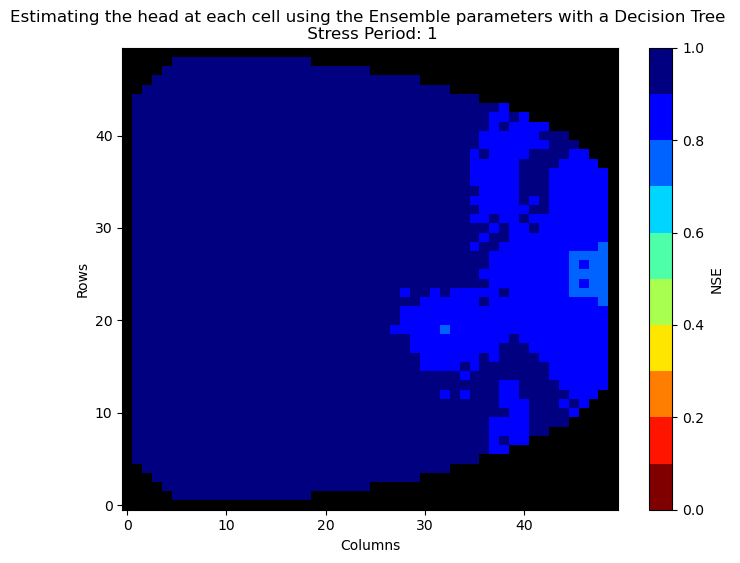

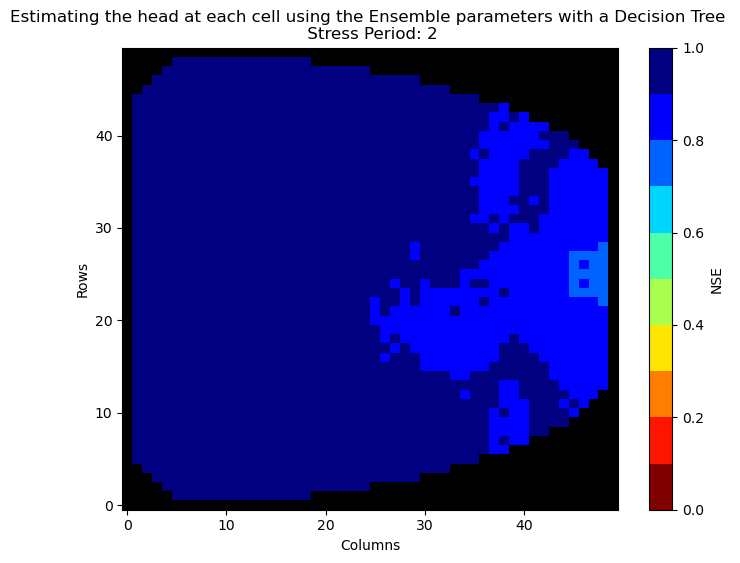

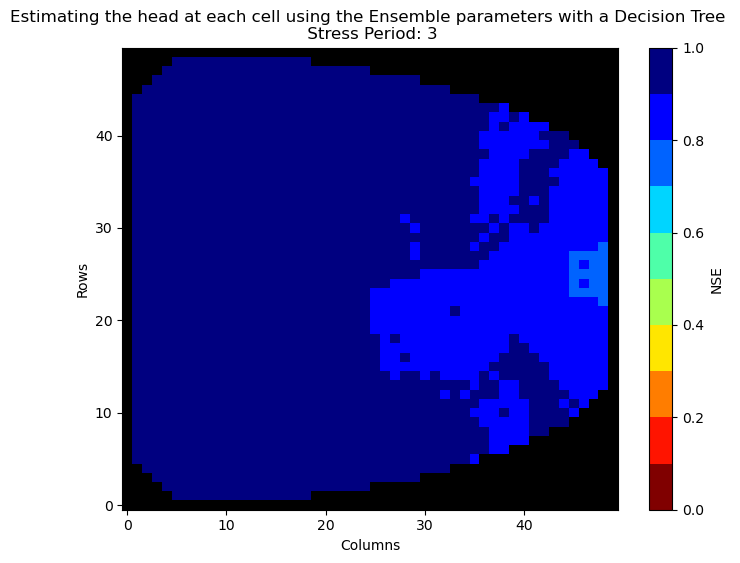

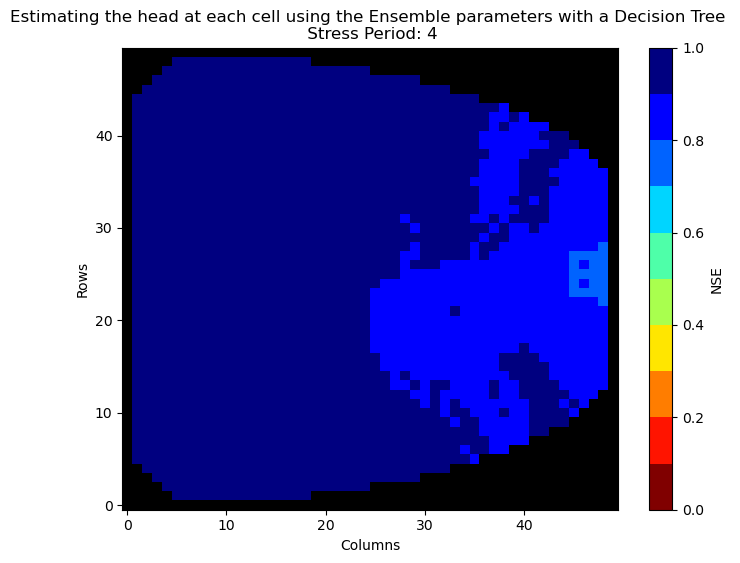

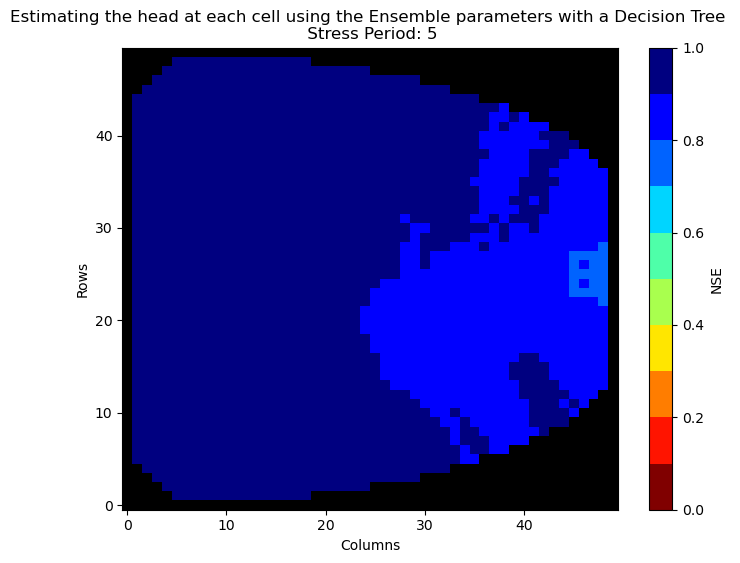

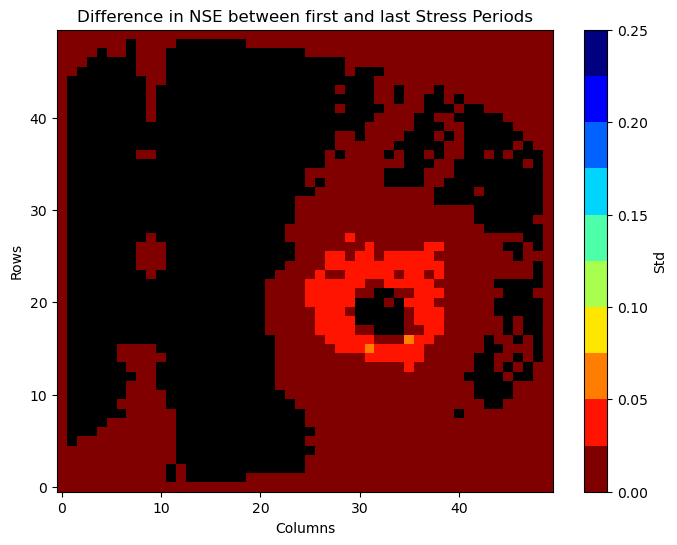

In [19]:


nse_list_remove = nse_list#[-50 if (np.any(np.isinf(x)) or np.any(np.isnan(x))) else x for x in nse_list] #np.any only nessesay if pasing NSE for each stress period individually 
#s = np.isnan(nse_list_remove)
nse_list_remove = np.reshape(nse_list_remove,(len(nse_list_remove),numTS))

print(len(nse_list_remove))

wellmesh = np.ndarray((numTS,50,50))
wellmesh[:] = -1e30

for k in range(numTS):
    for i in range(all_well_loc.shape[0]):
        wellmesh[k][int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = nse_list_remove[i][k]
        
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
cmap2 = cm.get_cmap("jet_r",lut=10)
cmap2.set_under("k")

#plt.figure(figsize=(8,6))
for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh[i], vmax = 1,cmap = cmap2, vmin = 0,shading='nearest')  
    plt.colorbar(label = 'NSE')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Estimating the head at each cell using the Ensemble parameters with a Decision Tree \n Stress Period: ' +str(i +1))
    #plt.pcolormesh(KK,GG,wellmesh, vmax = 1,cmap = cmap2, vmin = -1,shading='nearest')
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh[0] - wellmesh[-1], vmax = 0.25,cmap = cmap2, vmin = 0.,shading='nearest')
plt.colorbar(label = 'Std')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Difference in NSE between first and last Stress Periods')
plt.show() 

## Using Wells to predict stream Flow

In [11]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

well_sample = well_head_df.sample(frac = 0.1, axis = 1)

if numTS == 1:
    find_well = np.arange(stps-numTS,well_head_df.shape[1],5)
    well_head_df_1 = well_head_df[find_well]
    well_head_df_1.columns = np.arange(0,well_head_df_1.shape[1])
#print(well_head_df)
river_well_loc = np.where(all_well_loc[:,0] == 25)


#river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

#print(river_well_loc)
#print(len(all_well_loc))
CHBound_loc = np.where(all_well_loc[:,1] == 48) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

drop_locs2 = drop_locs*numTS #for transient
for i in range(1,numTS):
    drop_locs2 = np.append(drop_locs2,(drop_locs2+i)) #add the location of the ather stress period heads
    
#print(drop_locs)
#print(drop_locs[0])
#drop out the well heads 

if numTS == 1:
    well_head_noRiv = well_head_df_1.drop(drop_locs[0], axis = 1)
else:
    well_head_noRiv = well_head_df.drop(drop_locs2[0], axis = 1)
    
#NEcessary to track the features in the tree regressors to have the columns as strings
well_head_noRiv.columns = well_head_noRiv.columns.astype(str)

#Should probably use this now - it tracks the well location number with the index
well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])

print(well_head_noRiv.shape)


(595, 10059)


750 33 19


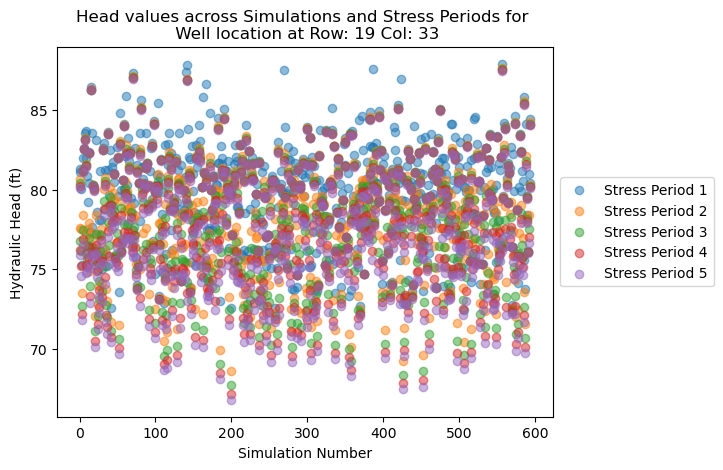

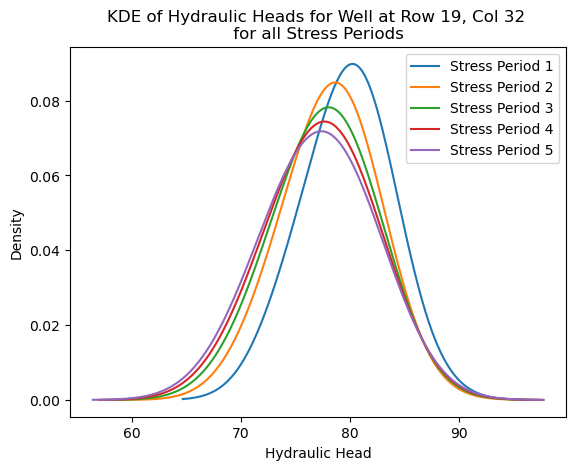

In [70]:
import seaborn as sns

wn = 750
#int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0])
print(wn,int(well_loc_df.loc[wn, 1]), int(well_loc_df.loc[wn, 0]))
for i in range(numTS):
    label = "Stress Period " + str(i+1)
    plt.scatter(range(well_head_df.shape[0]),well_head_df[wn*numTS + i], label=label, alpha = 0.5)
    #well_head_df.plot(kind='hexbin', x=wn*numTS + i, y = range(well_head_df.shape[0]))
    #plt.plot(range(well_head_df.shape[0]),np.repeat(well_head_df[wn*numTS + i].mean(),well_head_df.shape[0]),linewidth=3) #plot average as line across simulations
plt.xlabel('Simulation Number')
plt.ylabel('Hydraulic Head (ft)')
plt.title("Head values across Simulations and Stress Periods for \n Well location at Row: " +str(well_loc_df.loc[wn, 0])+ " Col: " + str(well_loc_df.loc[wn, 1]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for i in range(numTS):
    well_head_df[wn*numTS + i].plot.kde(label='Stress Period '+str(i+1), bw_method=1)
#     ax = well_head_df[wn*numTS + i].plot(kind='kde')
    #well_head_df[wn*numTS + i].plot(kind='hist', bins=12, alpha=0.5,secondary_y=True,)
#     ax.set_xlabel('Hydraulic Head')
    #sns.displot(well_head_df[wn*numTS + i])
plt.xlabel('Hydraulic Head')
plt.title('KDE of Hydraulic Heads for Well at Row 19, Col 32 \n for all Stress Periods ')
plt.legend()
plt.show()



C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


          1006       1007       1008       1009       1010       1011  \
0    81.253830  81.172272  81.089233  81.004128  80.650726  80.581001   
1    81.198868  81.181747  81.131119  81.050056  80.455803  80.455147   
2    80.070702  80.070351  80.069244  80.066620  79.363838  79.363823   
3    75.081421  75.012154  74.913147  74.792969  74.597908  74.564606   
4    81.423378  81.415627  81.407837  81.400024  80.777145  80.770920   
..         ...        ...        ...        ...        ...        ...   
590  78.180153  78.162804  78.145126  78.127151  77.586823  77.570564   
591  75.967606  75.956001  75.944206  75.932343  75.494072  75.486267   
592  80.534706  80.533661  80.528847  80.517410  79.851547  79.851532   
593  84.465950  84.453316  84.439812  84.425110  83.776314  83.767754   
594  80.567551  80.547699  80.527763  80.507744  79.939247  79.923630   

          1012       1013       1014       1015  ...        1044        1045  \
0    80.500610  80.418976  80.335541  80.01

AssertionError: Array size must be a multiple of ncpl

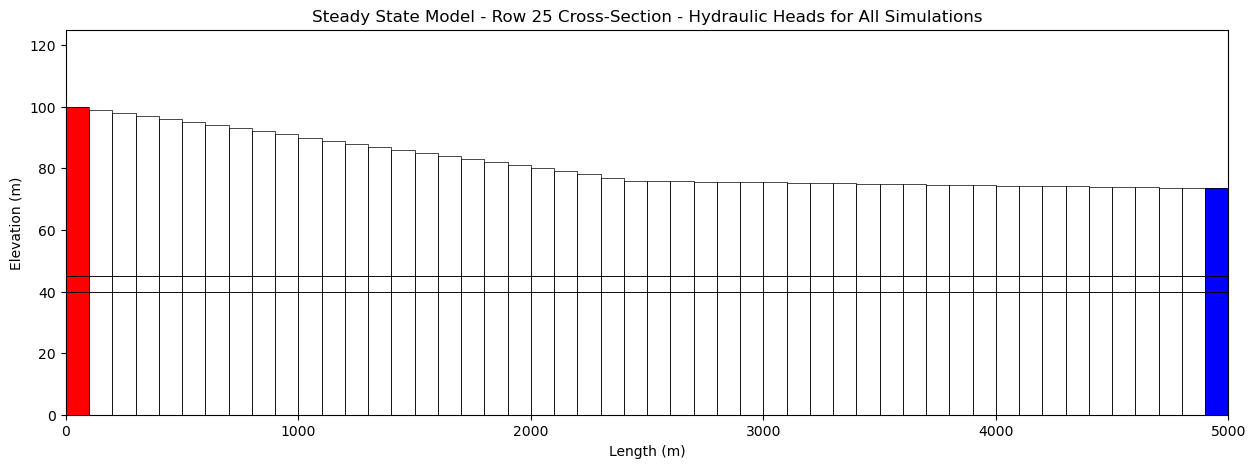

In [192]:
mn = "D:/mfoutput/transientDrawdown/ScenarioSfr750SteadyPumpTest_0.nam"

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
reach = ztop[25] - 5

m = flopy.modflow.Modflow.load(mn)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')

linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('Steady State Model - Row 25 Cross-Section - Hydraulic Heads for All Simulations')
xlabel = ax.set_xlabel('Length (m)')
ylabel = ax.set_ylabel('Elevation (m)')

well_head_onlyRiv = well_head_df[river_well_loc[0]] 

print(well_head_onlyRiv)

for i in well_head_onlyRiv.index:#rand_list: #rand_list[:100]:
#     modelname = "ScenarioSfrWell750Test3_"+str(i)
#     fname = modws+'/'+modelname+'.hds'
#     hdobj = flopy.utils.HeadFile(fname)
#     head = hdobj.get_data()
    wtup = xsect.plot_surface(well_head_onlyRiv.loc[i], lw=0.5, alpha=0.25)
  # wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.25, color='purple')
plt.plot(np.arange(0,5000,100),reach,color='green',linestyle='dashed', lw=1.5)
#plt.legend()


In [ ]:
#choosing one reach and finding the hyperparameters that best work for it 

rn = 25

outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)

#split quality function
split_criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
#Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,11)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

splitter = ['best']
# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease,
                'splitter': splitter}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dtr = DecisionTreeRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dtr_random = RandomizedSearchCV(estimator = dtr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dtr_random.fit(X_train, y_train)
best_pars = dtr_random.best_params_
print(best_pars)

from sklearn.tree import plot_tree


best_random = dtr_random.best_estimator_
y_pred = best_random.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

# _, ax = plt.subplots(figsize=(25, 25))
# _ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [151]:
best_pars_dt = {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 1.0, 'max_depth': 9, 'criterion': 'friedman_mse'}

In [184]:
# Split dataset into training set and test set using 20%
t0 = time.time()
n = 10

PredList = []
NSEList = []
importanceList = []
importanceListAll = []
depthlist = []

rn = 25

imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#numTS))#[:,1] #there is probably a better way to do this
#print(outputs)

for i in range(n):
    #well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)#, random_state=0) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    Tree = DecisionTreeRegressor(**best_pars_dt)

    # Train Decision Tree Classifer
    Tree = Tree.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = Tree.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))#.flatten()))
    depthlist.append(Tree.get_depth())
    feat_df = pd.DataFrame(Tree.feature_importances_, index = Tree.feature_names_in_.astype('int')) 
    imp_df = imp_df.merge(feat_df.rename(columns={0:i}), left_index=True, right_index = True)

    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Median NSE: ", np.median(NSEList))
print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results




print('Total time: ' + str(time.time()-t0))



Median NSE:  0.9105665804552756
Average Tree Depth:  9.0
Total time: 12.287962436676025


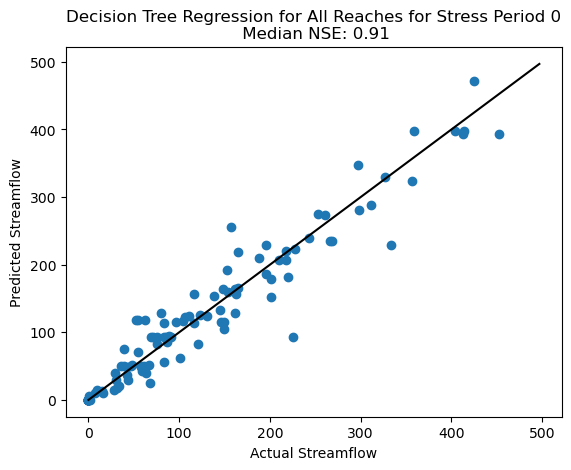

In [186]:
#imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
#print(KGE(y_pred,y_test.flatten()))

stp = 0
plt.figure()
if numTS != 1:    
    plt.scatter(y_test[:,stp], y_pred[:,stp])
else:
    plt.scatter(y_test[:], y_pred[:])

outmax = np.max(outputs)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for All Reaches for Stress Period " +str(stp) + "\n Median NSE: " +str(round(np.median(NSEList),2)) #Q at reach " + str(rn) +" - NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

## Tree using Wells to predict Qout

[   0    5   10   15   20   25   30   35   40   45   50   55   60   65
   70   75   80   85   90   95  100  105  110  115  120  125  130  135
  140  145  150  155  160  165  170  175  180  185  190  195  200  205
  210  215  220  225  230  235  240  245  250  255  260  265  270  275
  280  285  290  295  300  305  310  315  320  325  330  335  340  345
  350  355  360  365  370  375  380  385  390  395  400  405  410  415
  420  425  430  435  440  445  450  455  460  465  470  475  480  485
  490  495  500  505  510  515  520  530  535  540  545  550  555  560
  565  570  575  580  585  590  595  600  605  610  615  620  625  630
  635  640  645  650  655  660  665  670  675  680  685  690  695  700
  705  710  715  720  725  730  735  740  745  750  755  760  770  775
  780  785  790  795  800  805  810  815  820  825  830  835  840  845
  850  855  860  865  870  875  880  885  890  895  900  905  910  915
  920  925  930  935  940  945  950  955  960  965  970  975  980  985
  990 

C:\Users\davem\AppData\Local\Temp\ipykernel_15796\4006912573.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


Text(0.5, 1.0, 'Importance values for each cell in predicting flow at reach 25')

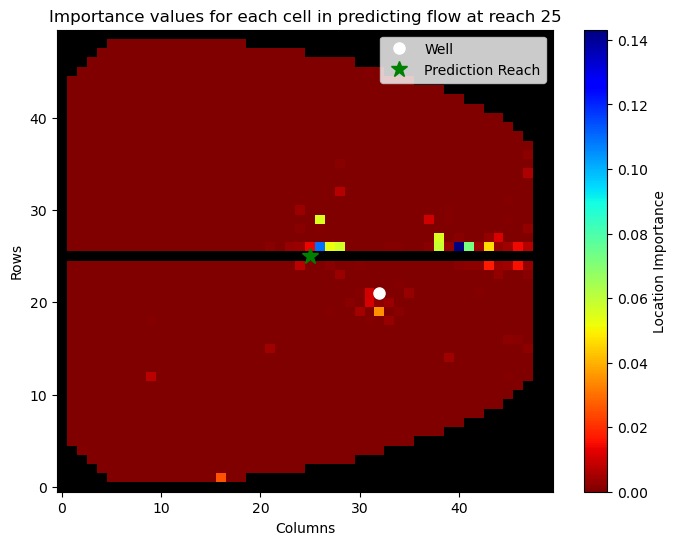

In [188]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid
dt_total_imp_df = imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
#Sum up all the stress periods for each well location
dt_AllTSimp = dt_total_imp_df.groupby(dt_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(dt_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_dt = np.ndarray((50,50))
wellmesh_dt[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in dt_AllTSimp.index:
        wellmesh_dt[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = dt_AllTSimp.loc[k]

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(dt_AllTSimp)
#vmax = 0.1
vmin = np.min(dt_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_dt,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.legend()
plt.title('Importance values for each cell in predicting flow at reach ' + str(rn))


In [62]:
wellmesh_AllTs = np.ndarray((numTS,50,50))
wellmesh_AllTs[:,:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs, axis = 0)
#for i in range(all_well_loc.shape[0]):

#featInTS = np.intersect1d(usedFeatures, featIndices)
#pd.DataFrame(importanceArr[featInTS])#just going to use step period 0
for i in range(numTS):
    featInTS = np.intersect1d(dt_total_imp_df.index, TSIndices+i)    
    for k in featInTS:
        wellnum = k // numTS
        wellmesh_AllTs[i,int(well_loc_df.loc[wellnum, 1]), int(well_loc_df.loc[wellnum, 0])] = dt_total_imp_df.loc[k] #np.sum(importanceList[:,i]) 
    

C:\Users\davem\AppData\Local\Temp\ipykernel_15796\3132623273.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


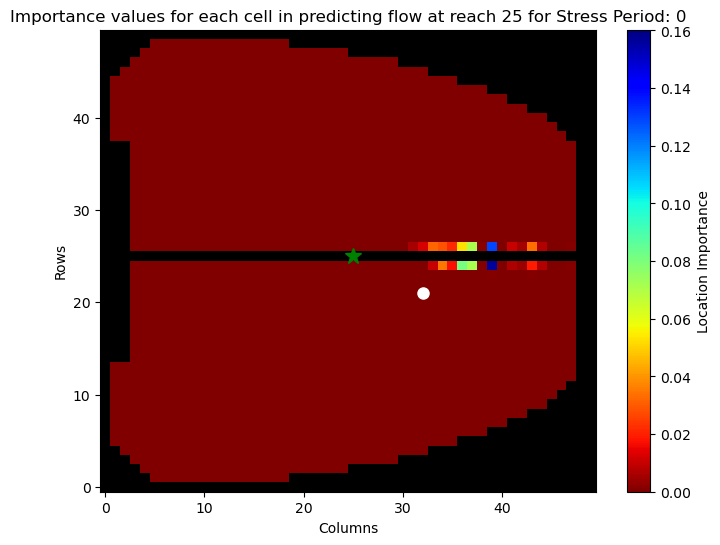

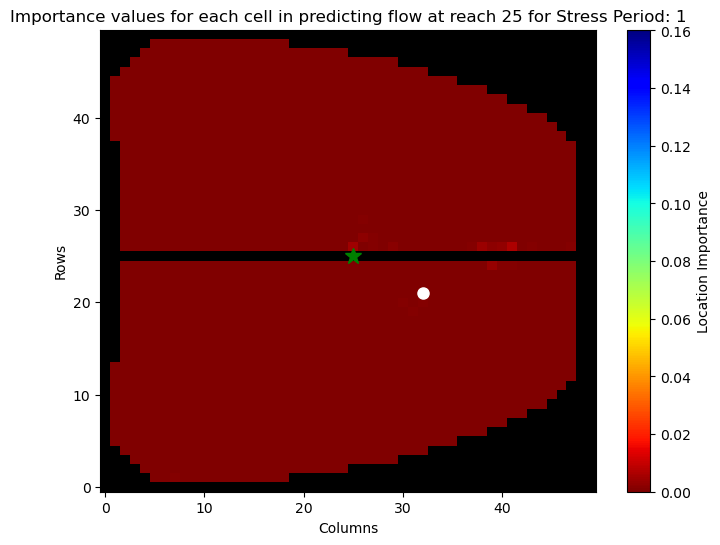

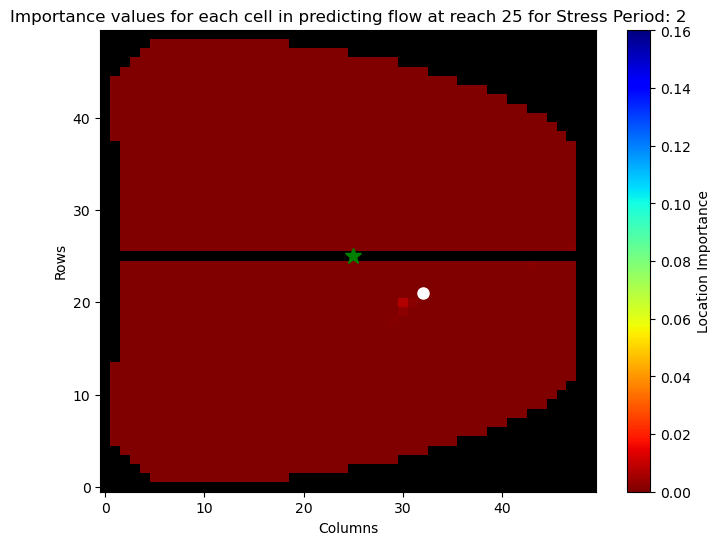

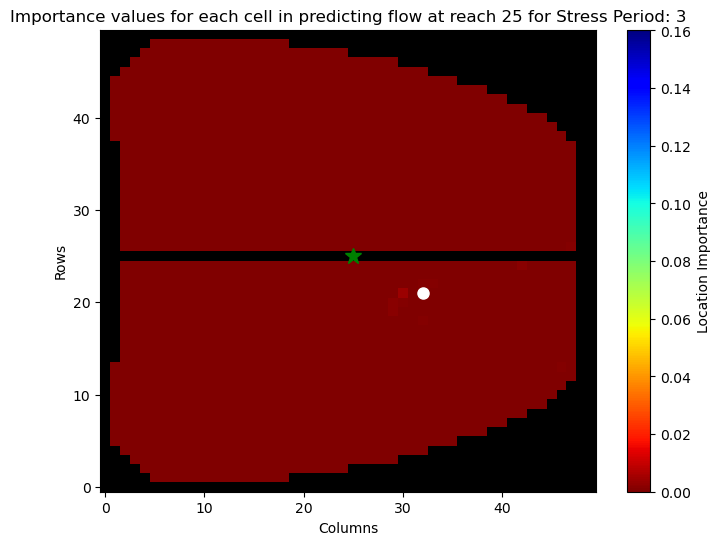

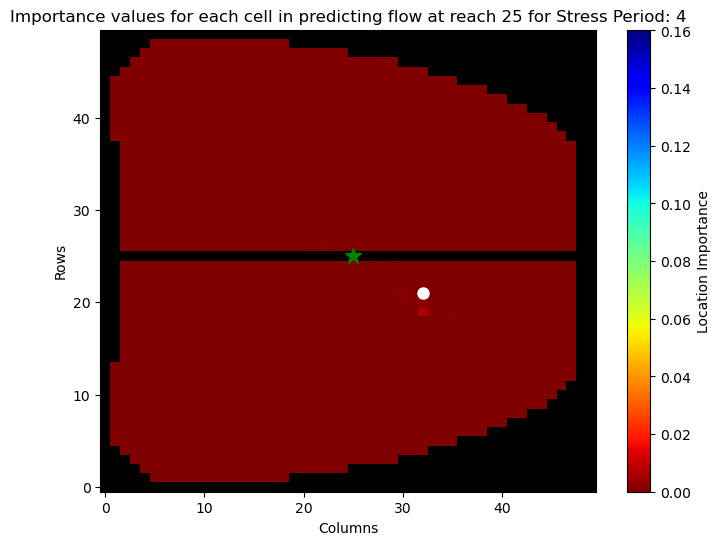

In [64]:
#wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(dt_AllTSimp)
#vmax = 1
vmin = np.min(dt_AllTSimp)

for i in range(numTS):
    plt.figure(figsize=(8,6))
    plt.pcolormesh(KK,GG,wellmesh_AllTs[i],vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
    plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
    plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")
    # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
    #plt.show()
    #plt.imshow(wellmesh, cmap='RdBu')
    plt.colorbar(label = "Location Importance")
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.title('Importance values for each cell in predicting flow at reach ' + str(rn)+' for Stress Period: ' +str(i))


In [29]:
# mostImportant = importance_df.sort_values(ascending=False)[:10]
# print(len(mostImportant.index))

# AllStrPerMI = mostImportant.index*numTS #for transient
# print(AllStrPerMI)
# first = AllStrPerMI
# for i in range(1,numTS+1):
#     AllStrPerMI = np.append(AllStrPerMI,(first+(i)))#add the location of the ather stress period heads
# #temp = [k for i in mostImportant.index for k in np.arange(i,i+numTS).tolist()] #very proud of this double list comprehension - expand it back out to include the all the time series
# print(mostImportant)
# print(AllStrPerMI)

10
Int64Index([4775, 4770, 4570, 4795, 4545, 4800, 4550, 4785, 4805, 4780], dtype='int64')
955    21.472034
954    19.032898
914     8.463551
959     8.338831
909     8.198339
960     4.472221
910     2.612243
957     2.344717
961     2.291125
956     2.026739
dtype: float64
[4775 4770 4570 4795 4545 4800 4550 4785 4805 4780 4776 4771 4571 4796
 4546 4801 4551 4786 4806 4781 4777 4772 4572 4797 4547 4802 4552 4787
 4807 4782 4778 4773 4573 4798 4548 4803 4553 4788 4808 4783 4779 4774
 4574 4799 4549 4804 4554 4789 4809 4784 4780 4775 4575 4800 4550 4805
 4555 4790 4810 4785]


In [30]:
# # Split dataset into training set and test set, default here is 30% test
# t0 = time.time()
# n = 100

# PredList = []
# NSEList = []
# miimportanceList = []
# miimportanceListAll = []

# #new_zone_q = ReachQdf.loc[well_head_noRiv.index]
# mostImpWellHead = well_head_df.loc[:,AllStrPerMI]
# print(mostImpWellHead)
# for i in range(n):
#     well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
#     X_train, X_test, y_train, y_test = train_test_split(mostImpWellHead,outputs, test_size=0.3, random_state=0)
#     # Create Random Forest Object
#     Tree = DecisionTreeRegressor(
#     #max_depth = 2 {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
#     )

#     # Train Decision Tree Classifer
#     Tree = Tree.fit(X_train,y_train)

#     #Predict the response for test dataset
#     y_pred = Tree.predict(X_test)
#     PredList.append(y_pred)
#     NSEList.append(NSE(y_pred, y_test))
#     #feature importance
#     #importanceList.append(Tree.feature_importances_)
#     implist = Tree.feature_importances_
#     temp = [sum(implist[i:i+numTS]) for i in range(0, len(implist), numTS)]
#     miimportanceList.append(temp)
#     miimportanceListAll.append(implist)
    
    
# #well head Tree NSE
  
# #print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
# print("Average NSE: ", np.mean(NSEList))

# t1 = time.time()

# total = t1-t0
# print('Total time: ' + str(total))

          4775       4770        4570        4795       4545        4800  \
0    68.906067  70.384895   98.492851   98.871437  64.555237   98.739357   
1    66.515030  67.913025  100.559120  101.137085  63.554932  101.004166   
2    66.254593  67.554787   98.635185   99.183830  63.479275   99.052681   
3    65.030655  65.967842   88.747360   89.174500  63.063000   89.077927   
4    67.952934  69.459412   97.947357   98.457420  64.196793   98.331024   
..         ...        ...         ...         ...        ...         ...   
590  66.249870  67.483147   94.011108   94.498497  63.517853   94.386711   
591  65.687469  66.757629   87.969978   88.379448  63.331066   88.286964   
592  67.075920  68.657974   96.934311   97.225983  63.728870   97.128868   
593  72.037987  73.726120   99.789101   99.486328  65.917389   99.477203   
594  67.185913  68.589378   97.321396   97.850594  63.906578   97.726532   

           4550       4785        4805       4780  ...       4780       4775  \
0     9

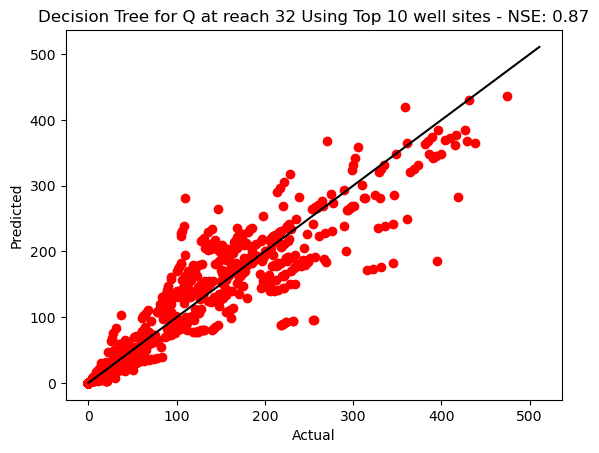

0     15.447049
1      1.772444
2     54.107759
3      1.724856
4      3.264781
5      1.847399
6      5.998658
7      2.547143
8      5.164599
9      2.143887
10     3.665208
11     2.316217
dtype: float64


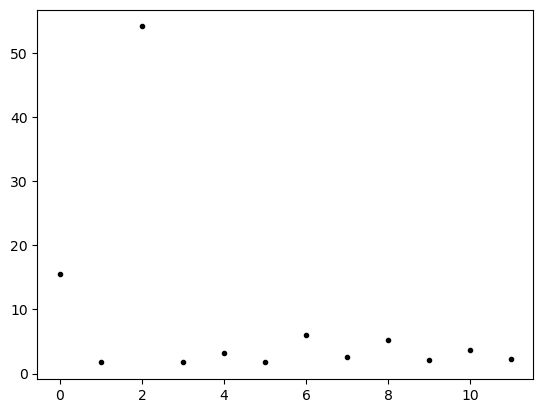

In [32]:
# #print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[10] > 0].index) / len(new_zone_q.index)))
# plt.figure()
# plt.scatter(y_test, y_pred, color='r')
# outmax = np.max(test_q)
# plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# title = "Decision Tree for Q at reach " + str(rn) +" Using Top 10 well sites - NSE: " + str(round(NSEList[-1],2))
# plt.title(title)
# #plt.yscale('log')
# #plt.xscale('log')
# #plt.legend()
# plt.show()


# #WellStreamimportance = Tree.feature_importances_
# #print(WellStreamimportance)
# miimportance_df = pd.DataFrame(miimportanceList).sum()
# #miimportance_df['wellnum'] = mostImpWellHead.columns
# print(miimportance_df)
# plt.plot(miimportance_df, '.k')

In [33]:
# feature importance Mapping
# miwellmesh = np.ndarray((50,50))
# miwellmesh[:,:] = -1e30
# #all_well_locNoRiv = np.delete(all_well_loc, river_well_loc[0], axis = 0)
# #for i in range(all_well_loc.shape[0]):
# for i,k in enumerate(mostImportant.index):
#     #if(all_well_loc[i,1] != 25):
#     miwellmesh[int(all_well_locNoRiv[k, 1]), int(all_well_locNoRiv[k, 0])] = miimportance_df[i] #np.sum(importanceList[:,i])  


C:\Users\davem\AppData\Local\Temp\ipykernel_6300\3615926601.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=10)


Text(0.5, 1.0, 'Importance values')

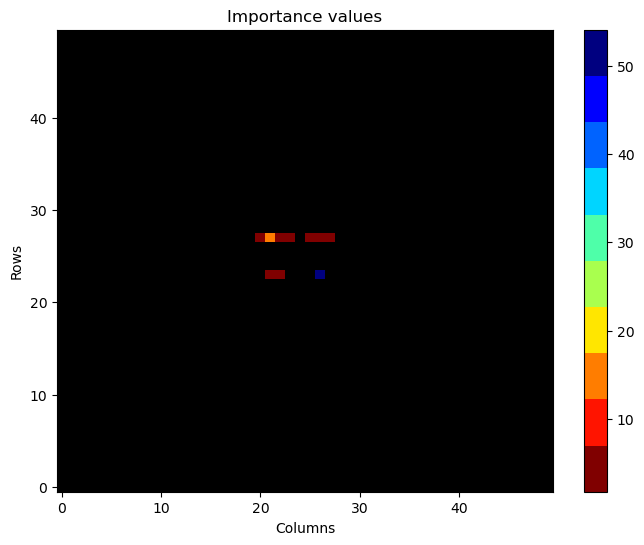

In [34]:
# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# #PLotting out the result grid

# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(miimportance_df)
# #vmax = 1
# vmin = np.min(miimportance_df)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,miwellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Importance values')


In [ ]:

# result = permutation_importance(
#     Tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )
# print(result.importances_mean)

# wellmesh = np.ndarray((50,50))
# wellmesh[:,:] = -1e30

# for i in range(all_well_loc.shape[0]):
#     wellmesh[int(all_well_loc[i, 1]), int(all_well_loc[i, 0])] = result.importances_mean[i] #np.sum(importanceList[:,i])

# #wellmesh = interp2d(kk,gg, wellmesh, kind='cubic')
# cmap2 = cm.get_cmap("jet_r",lut=10)
# cmap2.set_under("k")

# vmax = np.max(0.001)
# vmin = np.min(WellStreamimportance)

# plt.figure(figsize=(8,6))
# plt.pcolormesh(KK,GG,wellmesh,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
# # grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
# #plt.show()
# #plt.imshow(wellmesh, cmap='RdBu')
# plt.colorbar()
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.title('Permutation Importance values')

## Gradient Boosting

In [18]:
#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(GradientBoostingRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
#rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
rn = 25
outputs = np.asarray(outputdf[outputdf['reach'] == rn]['Qout']).reshape((len(simindex),numTS))#[:,1] #there is probably a better way to do this

#print(rand_well)
#Randomized cv search only works with a single output when using gradient boosting regressor, apparently, so using the last stress period data
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) 
#X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, new_zone_q[32], test_size=0.2)
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [int(x) for x in range(25,275,50)]
subsample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
splitter = ['best']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                'loss' : loss,
                'subsample':subsample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgr = GradientBoostingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgr_random = RandomizedSearchCV(estimator = xgr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgr_random.fit(X_train, y_train)# error_score='raise')
best_pars_gr = xgr_random.best_params_
print(best_pars_gr)

#from sklearn.tree import plot_tree


best_random_gr = xgr_random.best_estimator_
y_pred = best_random_gr.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
{'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10, 25], 'min_samples_leaf': [1, 2, 4], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrea

NameError: name 'best_random' is not defined

In [75]:
best_pars_gr = {'subsample': 0.5, 'n_estimators': 175, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber', 'criterion': 'friedman_mse'}

In [79]:
#Gradient Boosting-  Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList = []
importanceListAll = []

depthlist = []

gr_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]
rn = 25

for i in range(n):
    well_sample = well_head_noRiv#.sample(frac = 1, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs[:,-1], test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
    # Create Random Forest Object
    xgBest = GradientBoostingRegressor(**best_pars_gr)
   # Train Decision Tree Classifer
    xgBest.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = xgBest.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))
    #depthlist.append(xgBest.get_depth())
    #feature importance
    gr_feat_df = pd.DataFrame(xgBest.feature_importances_, index = xgBest.feature_names_in_.astype('int')) 
    gr_imp_df = gr_imp_df.merge(gr_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.mean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))



Average NSE:  0.9709940471736795
Total time: 9.53002142906189


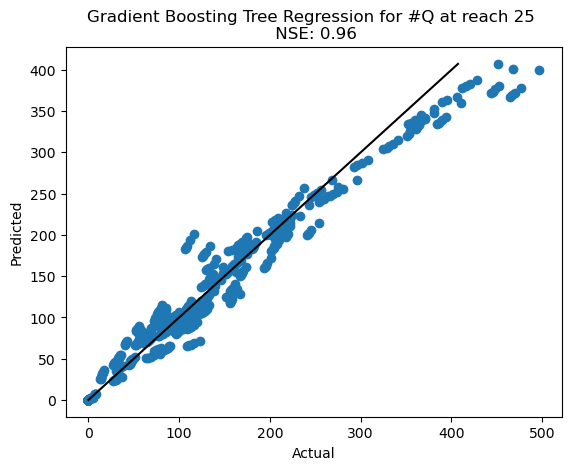

In [107]:
gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')


plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Gradient Boosting Tree Regression for #Q at reach " + str(rn) +" \n NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

0.9999999999999999
[    0     5    10 ... 10045 10050 10055]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.37857834678340563
[    1     6    11 ... 10046 10051 10056]
Number of Features used in Stress period 1: 1918
Sum of Importances in Stress period 1: 0.36082972642600386
[    2     7    12 ... 10047 10052 10057]
Number of Features used in Stress period 2: 1918
Sum of Importances in Stress period 2: 0.14638335448450523
[    3     8    13 ... 10048 10053 10058]
Number of Features used in Stress period 3: 1918
Sum of Importances in Stress period 3: 0.05521919486821175
[    4     9    14 ... 10049 10054 10059]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.05898937743787351


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\1692959661.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


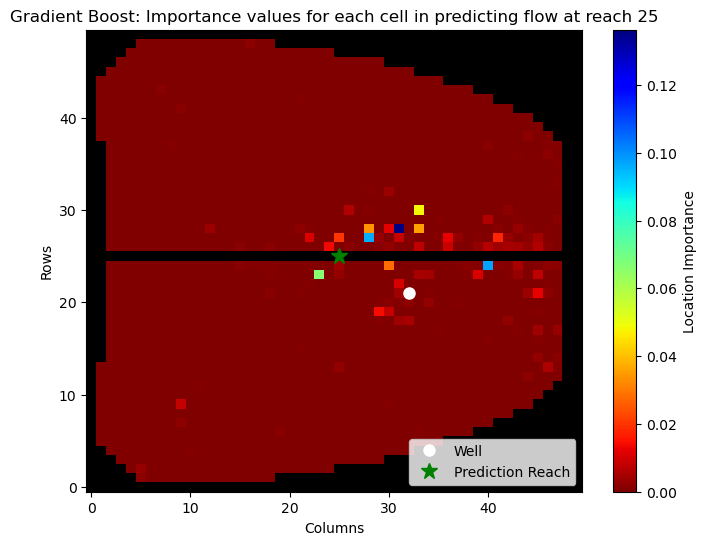

In [94]:
gr_total_imp_df = gr_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(gr_total_imp_df.sum())
#Sum up all the stress periods for each well location
gr_AllTSimp = gr_total_imp_df.groupby(gr_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(gr_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(gr_total_imp_df.loc[featInTS].sum()))
    
#Should probably use this now - it tracks the well location number with the index
#well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])


#feature importance Mapping
wellmesh_gr = np.ndarray((50,50))
wellmesh_gr[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in gr_AllTSimp.index:
        wellmesh_gr[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = gr_AllTSimp.loc[k]
# for i in range(len(importance_df.index)):

#PLotting out the result grid

cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(gr_AllTSimp)
#vmax = 0.1
vmin = np.min(gr_AllTSimp)

plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_gr,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Gradient Boost: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")

## Random Forest - Transient Drawdown Scenario

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
{'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [25, 75, 125, 175, 225], 'criterion': ['squared_error', 'friedman_mse'], 'max_features': [1.0, 'sqrt', 'log2'], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_leaf_nodes': [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None], 'min_impurity_decrease': [5, 15, 25, 35, 45]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}
RMSE:  24.772046629417623


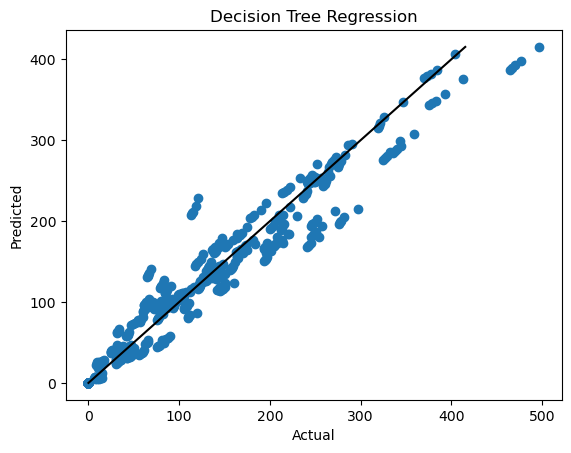

In [40]:
from sklearn.ensemble import RandomForestRegressor
#rn = 25

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

print(RandomForestRegressor().get_params().keys())
#choosing one well and finding the hyperparameters that best work for it 
rand_reach = np.random.randint(low=1,high=48)
#print(rand_well)
X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2)
n_estimators = [int(x) for x in range(25,275,50)]
max_sample = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]             
#split quality function
split_criterion = ['squared_error', 'friedman_mse']
#splitter = ['best']
bootstrap = ['True']
#Number of features to consider at every split
max_features = [1.0, 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(3,10)] #14 was the max depth, 3 is recommened, 10 seems high enough 
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
#maximum 
max_leaf_nodes = [18, 52, 86, 120, 154, 188, 222, 256, 290, 324, None]#[int(x) for x in range(int(np.max(y_train)**(1/2)),int(np.max(y_train)),int(np.max(y_train)/10))]
#max_leaf_nodes.append(None)

#min weight fraction leaf - need to look into this one 
#min_weight_fraction_leaf = [0.0]

min_imp_decrease = [int(x) for x in range(5,55,10)]
#min_imp_decrease.append(0)
#cost complexcity prunning 
ccp_alpha = [0.0]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
                #'bootstrap' : bootstrap,
                'max_samples':max_sample,
                'n_estimators':n_estimators,
                'criterion' : split_criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              # 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'min_impurity_decrease':min_imp_decrease}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = rfr, scoring = 'neg_root_mean_squared_error',param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfr_random.fit(X_train, y_train)
best_pars_rf = rfr_random.best_params_
print(best_pars_rf)

#from sklearn.tree import plot_tree


best_random_rf = rfr_random.best_estimator_
y_pred = best_random_rf.predict(X_test)
#well head Tree NSE
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
#print("NSE: ", NSE(y_pred, y_test))
#label='Prediction to Test Values for Hyperparameter Tuned Tree'
plt.scatter(y_test, y_pred)  
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression")
# plt.xlim(60,100)
# plt.ylim(60,100)
#plt.legend()
plt.show()

#_, ax = plt.subplots(figsize=(25, 25))
#_ = plot_tree(best_random, ax=ax)#, feature_names=col_names)

In [83]:
best_pars_rf = {'n_estimators': 125, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 15, 'max_samples': 0.9, 'max_leaf_nodes': 154, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse'}

In [98]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

PredList = []
NSEList = []
importanceList_rf = []
importanceListAll_rf = []
depthlist = []

rf_imp_df = pd.DataFrame(index = well_head_noRiv.columns.astype('int'))

rn = 25

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(well_head_noRiv, outputs, test_size=0.2) #random_state=1) #changed the random state to 1 - 2/27/23
 
    RF = RandomForestRegressor(**best_pars_rf)
    
    RF = RF.fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    PredList.append(y_pred)
    NSEList.append(NSE(y_pred, y_test))

    rf_feat_df = pd.DataFrame(RF.feature_importances_, index = RF.feature_names_in_.astype('int')) 
    rf_imp_df = rf_imp_df.merge(rf_feat_df.rename(columns={0:i}), left_index=True, right_index = True)
    
    
#well head Tree NSE
  
#print("RMSE: ", metrics.mean_squared_error(y_test, y_pred, squared=False))
print("Average NSE: ", np.nanmean(NSEList))
#print("Average Tree Depth: ", np.mean(depthlist))
# Plot the results



t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))


Average NSE:  0.9619705834847866
Total time: 736.5224423408508


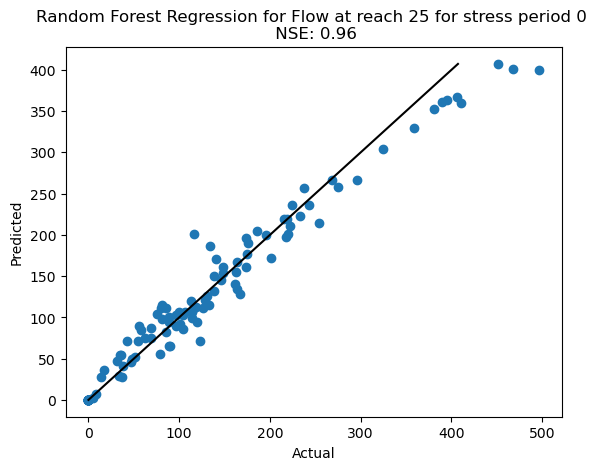

In [105]:
rf_imp_df.to_pickle('Drawdown_RF_Impdf.pkl')


stp = 0
plt.figure()
plt.scatter(y_test[:,stp], y_pred[:,stp])
outmax = np.max(y_pred)
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual")
plt.ylabel("Predicted")
title = "Random Forest Regression for Flow at reach " + str(rn) +" for stress period " + str(stp) + " \n NSE: " + str(round(NSEList[-1],2))
plt.title(title)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

1.0
[    0     5    10 ... 10045 10050 10055]
Number of Features used in Stress period 0: 1895
Sum of Importances in Stress period 0: 0.823348439733127
[    1     6    11 ... 10046 10051 10056]
Number of Features used in Stress period 1: 1918
Sum of Importances in Stress period 1: 0.06946328788040948
[    2     7    12 ... 10047 10052 10057]
Number of Features used in Stress period 2: 1918
Sum of Importances in Stress period 2: 0.033731303153823874
[    3     8    13 ... 10048 10053 10058]
Number of Features used in Stress period 3: 1918
Sum of Importances in Stress period 3: 0.031061114775394506
[    4     9    14 ... 10049 10054 10059]
Number of Features used in Stress period 4: 1918
Sum of Importances in Stress period 4: 0.04239585445724538


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\4001706885.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r")#,lut=20)


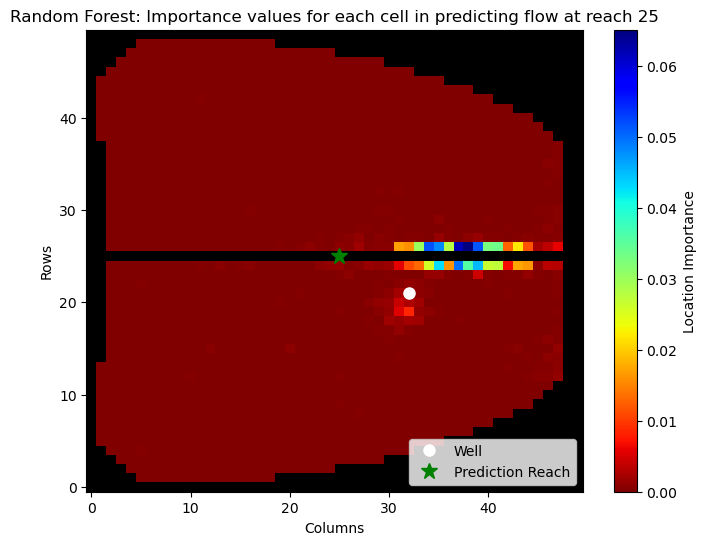

In [95]:
rf_total_imp_df = rf_imp_df.sum(axis=1) / n #sum up all the trees and normalize to 1 
print(rf_total_imp_df.sum())
#Sum up all the stress periods for each well location
rf_AllTSimp = rf_total_imp_df.groupby(rf_total_imp_df.index // numTS).sum()

#get indicies of every feature per TS (stressperiod)
TSIndices = np.arange(0,int(well_head_noRiv.columns[-1])+1,numTS)

for i in range(numTS):
    featInTS = np.intersect1d(rf_total_imp_df.index, TSIndices+i)
    print(featInTS)
    print("Number of Features used in Stress period " + str(i) + ": " + str(len(featInTS)))
    print("Sum of Importances in Stress period " + str(i) + ": " + str(rf_total_imp_df.loc[featInTS].sum()))
    
#feature importance Mapping
wellmesh_rf = np.ndarray((50,50))
wellmesh_rf[:,:] = -1e30
#all_well_locNoRiv = np.delete(all_well_loc, drop_locs[0], axis = 0)

for k in rf_AllTSimp.index:
        wellmesh_rf[int(well_loc_df.loc[k, 1]), int(well_loc_df.loc[k, 0])] = rf_AllTSimp.loc[k]


cmap2 = cm.get_cmap("jet_r")#,lut=20)
cmap2.set_under("k")

vmax = np.max(rf_AllTSimp)
#vmax = 0.1
vmin = np.min(rf_AllTSimp)
plt.figure(figsize=(8,6))
plt.pcolormesh(KK,GG,wellmesh_rf,vmax = vmax, vmin = vmin, cmap = cmap2, shading='nearest')
plt.plot(32, 21, marker="o", markersize=8, color="White", linestyle = "None", label="Well")
plt.plot(rn, 25, marker="*", markersize=12, color="Green", linestyle = "None",label="Prediction Reach")

# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')
#plt.show()
#plt.imshow(wellmesh, cmap='RdBu')
plt.colorbar(label = "Location Importance")
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Random Forest: Importance values for each cell in predicting flow at reach ' + str(rn))
plt.legend(loc="lower right")


[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


C:\Users\davem\AppData\Local\Temp\ipykernel_15796\498297761.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

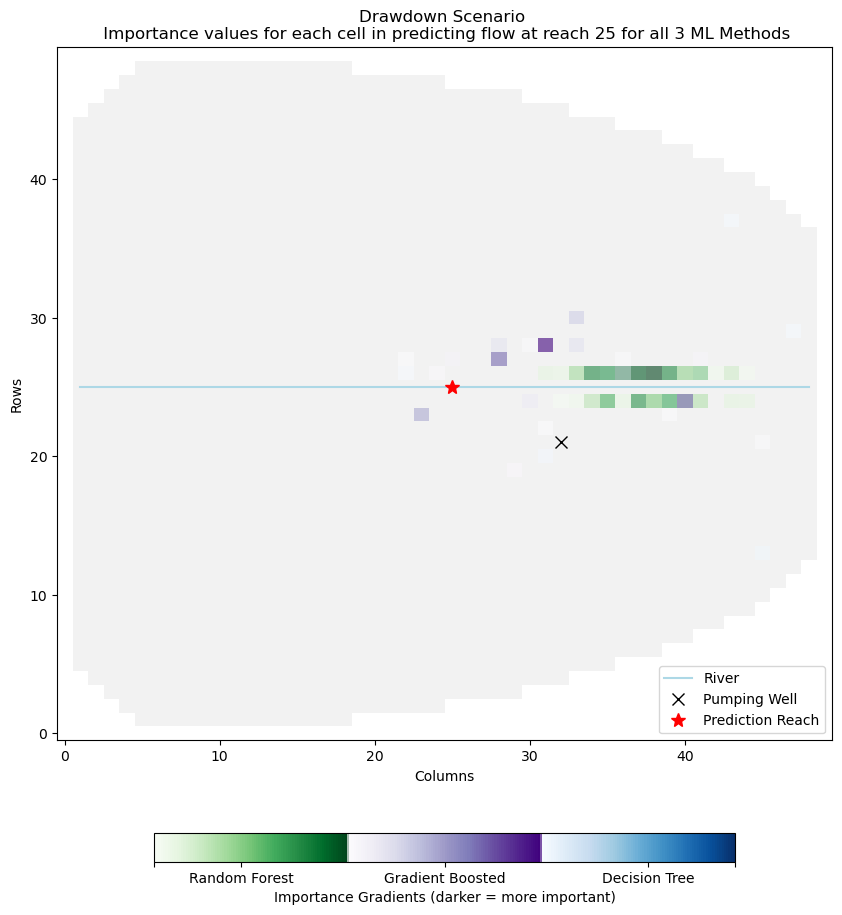

In [101]:
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_dt, wellmesh_dt < 0.01)
vmaxdt = np.max(wellmesh_dt)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = vmax, vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()